<a href="https://colab.research.google.com/github/5237-mests/time-series-portfolio-optimization/blob/main/notebooks/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.26.4 yfinance pmdarima torch pyportfolioopt matplotlib seaborn statsmodels scipy

In [1]:
# Install required packages if needed: pip install yfinance pmdarima torch pyportfolioopt matplotlib seaborn statsmodels scipy
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.discrete_allocation import get_latest_prices
from datetime import datetime, timedelta

# Task 1: Preprocess and Explore the Data

In [2]:
# Task 1: Preprocess and Explore the Data
tickers = ['TSLA', 'BND', 'SPY']
data = yf.download(tickers, start='2015-07-01', end='2025-08-01')  # End +1 day to include July 31

/tmp/ipython-input-1385896135.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2015-07-01', end='2025-08-01')  # End +1 day to include July 31
[*********************100%***********************]  3 of 3 completed


In [3]:
# Use Adj Close for analysis
adj_close = data['Close']
adj_close.dropna(inplace=True)

/tmp/ipython-input-817155515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close.dropna(inplace=True)


In [4]:
# Data Cleaning
print("Basic Statistics:\n", adj_close.describe())
print("Missing Values:\n", adj_close.isnull().sum())

Basic Statistics:
 Ticker          BND          SPY         TSLA
count   2536.000000  2536.000000  2536.000000
mean      68.470959   334.311196   132.032524
std        4.554576   126.541098   120.941737
min       60.779133   155.869797     9.578000
25%       64.655315   230.083923    18.968500
50%       67.610085   305.298462    94.977669
75%       71.891140   420.468666   236.888332
max       77.318260   637.099976   479.859985
Missing Values:
 Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


In [5]:
# Daily Returns
returns = adj_close.pct_change().dropna()

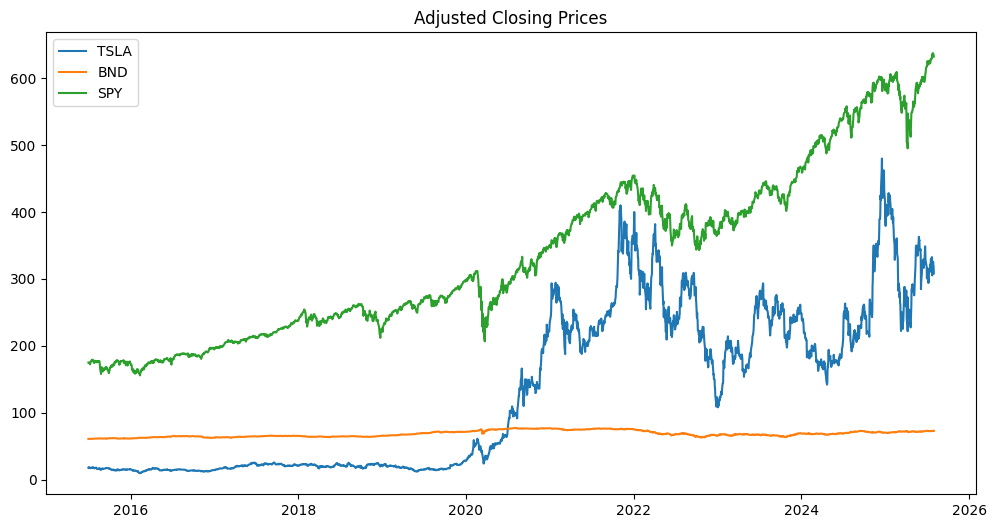

In [6]:
# EDA: Visualize Closing Prices
plt.figure(figsize=(12,6))
for ticker in tickers:
    plt.plot(adj_close[ticker], label=ticker)
plt.title('Adjusted Closing Prices')
plt.legend()
# plt.savefig('closing_prices.png')
# plt.close()
plt.show()

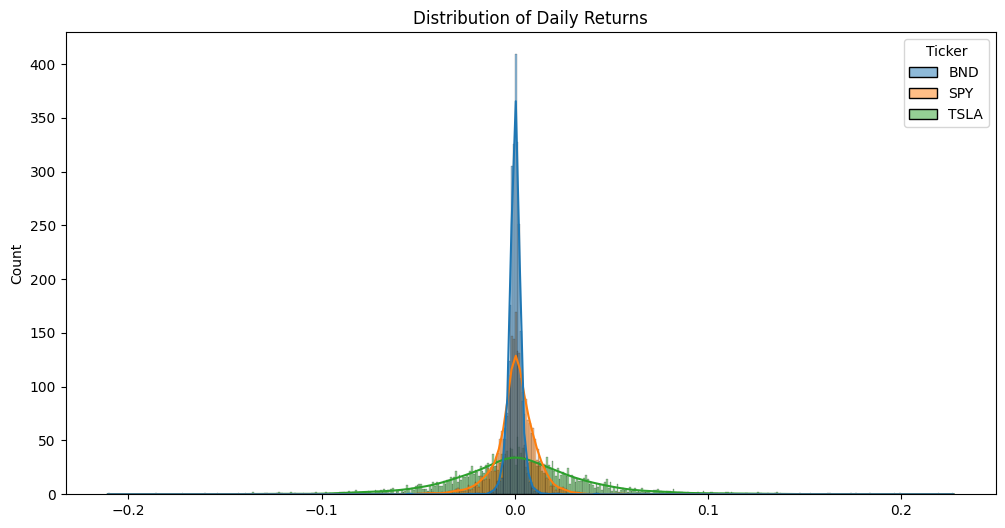

In [7]:
# Daily Percentage Change
plt.figure(figsize=(12,6))
sns.histplot(returns, kde=True)
plt.title('Distribution of Daily Returns')
plt.savefig('daily_returns_hist.png')
# plt.close()
plt.show()

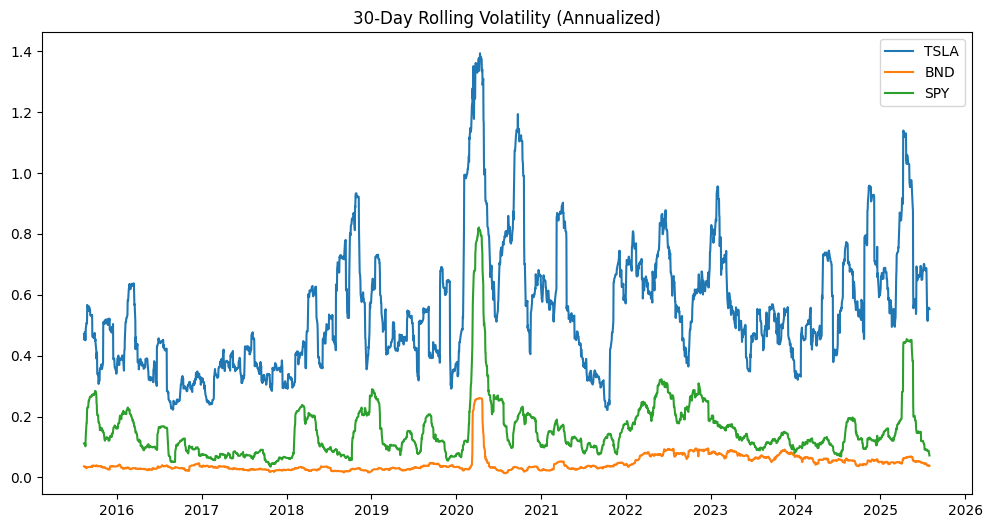

In [8]:
# Rolling Volatility (30-day std dev of returns)
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # Annualized
plt.figure(figsize=(12,6))
for ticker in tickers:
    plt.plot(rolling_vol[ticker], label=ticker)
plt.title('30-Day Rolling Volatility (Annualized)')
plt.legend()
plt.savefig('rolling_volatility.png')
# plt.close()
plt.show()

In [9]:
# Outlier Detection: Days with |return| > 5%
outliers = returns[abs(returns) > 0.05]
print("Outliers (high/low returns):\n", outliers)

Outliers (high/low returns):
 Ticker      BND  SPY  TSLA
Date                      
2015-07-02  NaN  NaN   NaN
2015-07-06  NaN  NaN   NaN
2015-07-07  NaN  NaN   NaN
2015-07-08  NaN  NaN   NaN
2015-07-09  NaN  NaN   NaN
...         ...  ...   ...
2025-07-25  NaN  NaN   NaN
2025-07-28  NaN  NaN   NaN
2025-07-29  NaN  NaN   NaN
2025-07-30  NaN  NaN   NaN
2025-07-31  NaN  NaN   NaN

[2535 rows x 3 columns]


In [10]:
# Stationarity Test (ADF on TSLA Adj Close and Returns)
adf_close = adfuller(adj_close['TSLA'])
adf_returns = adfuller(returns['TSLA'])
print(f"ADF Test on TSLA Close: p-value = {adf_close[1]} (Stationary if <0.05)")
print(f"ADF Test on TSLA Returns: p-value = {adf_returns[1]}")

ADF Test on TSLA Close: p-value = 0.5560449619009475 (Stationary if <0.05)
ADF Test on TSLA Returns: p-value = 0.0


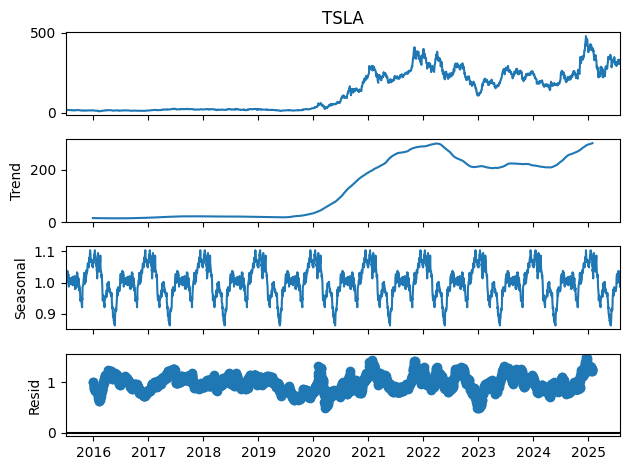

In [11]:
# Decomposition for Seasonality/Trends (TSLA)
decomp = seasonal_decompose(adj_close['TSLA'], model='multiplicative', period=252)
decomp.plot()
plt.savefig('tsla_decomposition.png')
# plt.close()
plt.show()

In [12]:
# Volatility Analysis: VaR (95%) and Sharpe Ratio
var_95 = returns.quantile(0.05)
sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
print("95% VaR:\n", var_95)
print("Sharpe Ratios:\n", sharpe)

95% VaR:
 Ticker
BND    -0.004897
SPY    -0.017182
TSLA   -0.054657
Name: 0.05, dtype: float64
Sharpe Ratios:
 Ticker
BND     0.357058
SPY     0.791849
TSLA    0.772377
dtype: float64


In [ ]:
# Insights: TSLA shows upward trend with high volatility; BND stable; SPY moderate.

# Task 2: Develop Time Series Forecasting Models (Focus on TSLA)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=13639.791, Time=4.05 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=13647.752, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=13649.076, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=13649.063, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=13646.472, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=13653.473, Time=1.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=13653.536, Time=1.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=inf, Time=6.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=inf, Time=7.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=13652.181, Time=0.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=13651.207, Time=2.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=13651.553, Time=2.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=inf, Time=7.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=2.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[5] intercept   : AIC=inf, Time=2.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=5.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[5] intercept   : AIC=13612.351, Time=4.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,1)[5] intercept   : AIC=13616.926, Time=3.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,0)[5] intercept   : AIC=13617.046, Time=3.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,1)[5] intercept   : AIC=13608.634, Time=6.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,0)[5] intercept   : AIC=13610.459, Time=5.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[5] intercept   : AIC=13603.484, Time=8.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,2)[5] intercept   : AIC=13609.001, Time=8.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,2)[5] intercept   : AIC=inf, Time=9.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,2)[5] intercept   : AIC=inf, Time=9.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(2,0,2)[5] intercept   : AIC=inf, Time=8.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[5] intercept   : AIC=inf, Time=6.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(2,0,2)[5] intercept   : AIC=inf, Time=8.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[5] intercept   : AIC=inf, Time=8.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(2,0,2)[5] intercept   : AIC=13599.853, Time=9.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,0,2)[5] intercept   : AIC=13603.849, Time=9.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(2,0,1)[5] intercept   : AIC=13603.503, Time=9.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,0,1)[5] intercept   : AIC=13607.551, Time=6.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(2,0,2)[5] intercept   : AIC=13620.895, Time=10.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(2,0,2)[5] intercept   : AIC=13605.894, Time=10.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(2,0,2)[5]             : AIC=13598.184, Time=5.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,0,2)[5]             : AIC=13602.546, Time=4.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(2,0,1)[5]             : AIC=13602.157, Time=3.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,0,1)[5]             : AIC=13605.839, Time=4.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(2,0,2)[5]             : AIC=inf, Time=4.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,2)[5]             : AIC=inf, Time=6.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(2,0,2)[5]             : AIC=13619.359, Time=5.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[5]             : AIC=13602.883, Time=4.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(2,0,2)[5]             : AIC=13605.116, Time=4.29 sec

Best model:  ARIMA(3,1,4)(2,0,2)[5]          
Total fit time: 236.422 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/di

ARIMA Metrics: MAE=62.94856271154653, RMSE=77.99410001405211, MAPE=nan%
LSTM Metrics: MAE=30.692849159240723, RMSE=40.44168105731555, MAPE=11.457917071065053%


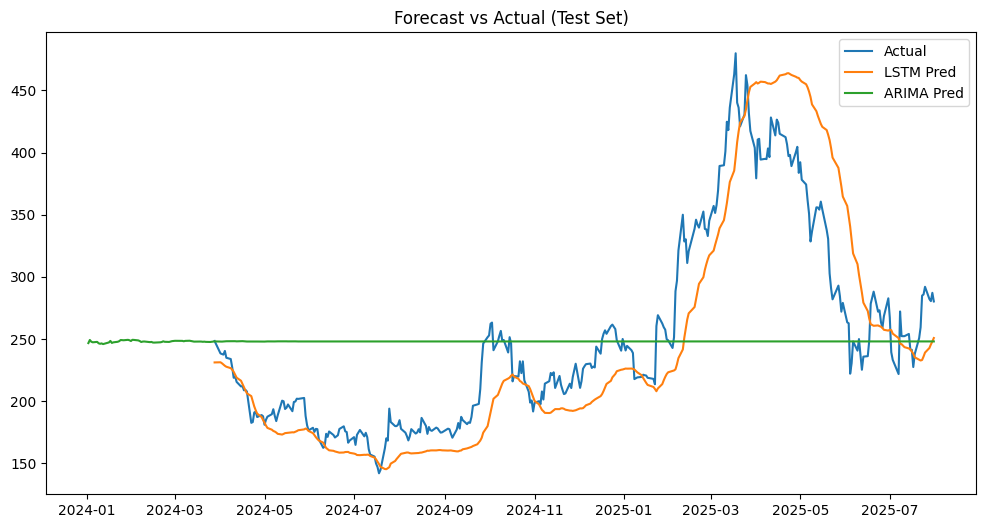

In [13]:
# Task 2: Develop Time Series Forecasting Models (Focus on TSLA)
tsla_close = adj_close['TSLA'].values.reshape(-1,1)
scaler = MinMaxScaler()
tsla_scaled = scaler.fit_transform(tsla_close)

# Chronological Split: Train 2015-2023, Test 2024-2025 (~80/20)
split_date = '2024-01-01'
train = adj_close['TSLA'][:split_date]
test = adj_close['TSLA'][split_date:]

# ARIMA/SARIMA with auto_arima
arima_model = auto_arima(train, seasonal=True, m=5, trace=True, error_action='ignore', suppress_warnings=True)
arima_fit = ARIMA(train, order=arima_model.order, seasonal_order=arima_model.seasonal_order).fit()
arima_pred = arima_fit.forecast(len(test))
mae_arima = mean_absolute_error(test, arima_pred)
rmse_arima = sqrt(mean_squared_error(test, arima_pred))
mape_arima = np.mean(np.abs((test - arima_pred) / test)) * 100
print(f"ARIMA Metrics: MAE={mae_arima}, RMSE={rmse_arima}, MAPE={mape_arima}%")

# LSTM Model
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(1, 50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 50)
        c0 = torch.zeros(1, x.size(0), 50)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# Prepare data for LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
train_scaled = scaler.transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))

# Create datasets, ensuring alignment
X_train, y_train = create_dataset(train_scaled, time_step)
test_data = np.concatenate((train_scaled[-time_step:], test_scaled))  # Include last time_step from train
X_test, y_test = create_dataset(test_data, time_step)

# Trim to match test set length
test_len = len(test) - time_step
X_test = X_test[:test_len]
y_test = y_test[:test_len]

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train LSTM
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    inputs = torch.from_numpy(X_train).float()
    labels = torch.from_numpy(y_train).float()
    outputs = model(inputs)
    loss = criterion(outputs, labels.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Predict on test set
model.eval()
lstm_pred_scaled = model(torch.from_numpy(X_test).float()).detach().numpy()
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Align test indices
test_indices = test.index[time_step:time_step + len(lstm_pred)]
if len(test_indices) != len(lstm_pred):
    min_len = min(len(test_indices), len(lstm_pred))
    test_indices = test_indices[:min_len]
    lstm_pred = lstm_pred[:min_len]
    lstm_pred_scaled = lstm_pred_scaled[:min_len]
    y_test = y_test[:min_len]

# Evaluate LSTM
mae_lstm = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1,1)), lstm_pred)
rmse_lstm = sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), lstm_pred))
mape_lstm = np.mean(np.abs((scaler.inverse_transform(y_test.reshape(-1,1)).flatten() - lstm_pred.flatten()) / scaler.inverse_transform(y_test.reshape(-1,1)).flatten())) * 100
print(f"LSTM Metrics: MAE={mae_lstm}, RMSE={rmse_lstm}, MAPE={mape_lstm}%")

# Plot Predictions
plt.figure(figsize=(12,6))
plt.plot(test_indices, scaler.inverse_transform(y_test.reshape(-1,1)), label='Actual')
plt.plot(test_indices, lstm_pred, label='LSTM Pred')
plt.plot(test.index, arima_pred, label='ARIMA Pred')
plt.legend()
plt.title('Forecast vs Actual (Test Set)')
plt.savefig('model_predictions.png')
# plt.close()
plt.show()



# Task 3: Forecast Future Market Trends (6-12 months, ~252 days)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast Trend:  Upward
Volatility: Confidence intervals widen over time, implying decreasing reliability for long-term forecasts.
Opportunities: Potential growth if upward trend; Risks: High uncertainty in volatile stock like TSLA.


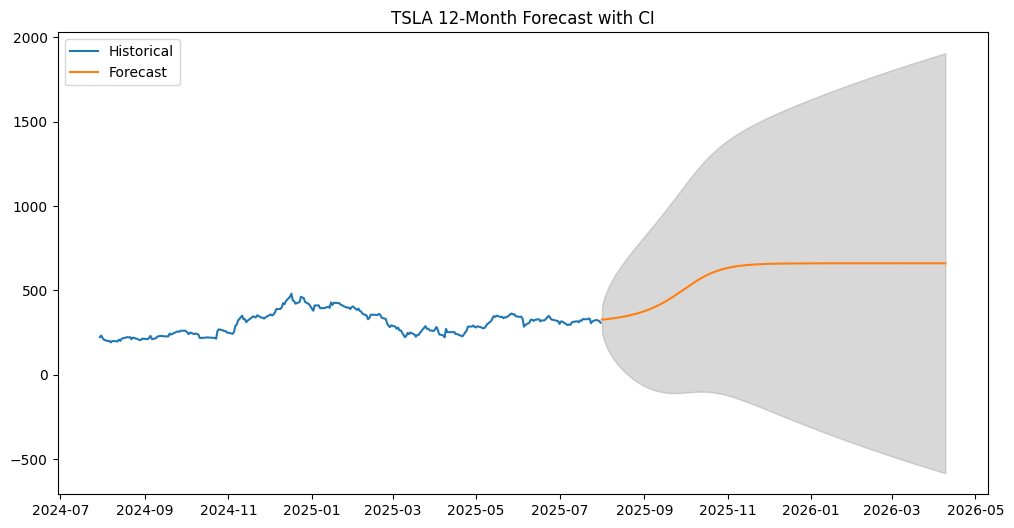

In [14]:

# Task 3: Forecast Future Market Trends (6-12 months, ~252 days)
forecast_steps = 252
future_dates = [adj_close.index[-1] + timedelta(days=i) for i in range(1, forecast_steps+1)]

# ARIMA Forecast
arima_future = arima_fit.forecast(forecast_steps)

# LSTM Forecast
last_sequence = tsla_scaled[-time_step:].reshape(1, time_step, 1)
lstm_future = []
for _ in range(forecast_steps):
    pred = model(torch.from_numpy(last_sequence).float()).detach().numpy()
    lstm_future.append(pred[0][0])
    last_sequence = np.append(last_sequence[:,1:,:], pred.reshape(1,1,1), axis=1)

lstm_future = scaler.inverse_transform(np.array(lstm_future).reshape(-1,1)).flatten()

# Use LSTM for final forecast
forecast = pd.Series(lstm_future, index=future_dates)

# Confidence Intervals (Approximate for LSTM using std of errors)
test_errors = scaler.inverse_transform(y_test.reshape(-1,1)).flatten() - lstm_pred.flatten()
error_std = np.std(test_errors)
ci_upper = forecast + 1.96 * error_std * np.sqrt(np.arange(1, forecast_steps+1))
ci_lower = forecast - 1.96 * error_std * np.sqrt(np.arange(1, forecast_steps+1))

plt.figure(figsize=(12,6))
plt.plot(adj_close['TSLA'][-252:], label='Historical')
plt.plot(forecast, label='Forecast')
plt.fill_between(forecast.index, ci_lower, ci_upper, color='gray', alpha=0.3)
plt.title('TSLA 12-Month Forecast with CI')
plt.legend()
plt.savefig('future_forecast.png')
# plt.close()

# Interpretation
print("Forecast Trend: ", "Upward" if forecast.iloc[-1] > forecast.iloc[0] else "Downward or Stable")
print("Volatility: Confidence intervals widen over time, implying decreasing reliability for long-term forecasts.")
print("Opportunities: Potential growth if upward trend; Risks: High uncertainty in volatile stock like TSLA.")

In [ ]:
# Interpretation


# Task 4: Optimize Portfolio Based on Forecast

/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Min Volatility Portfolio: Weights= OrderedDict([('TSLA', 0.9451124536003748), ('BND', 0.0548875463996251), ('SPY', 0.0)]) Return= 1.081027216394574 Vol= 0.053967421853755304 Sharpe= 20.031107272902847
Max Sharpe Portfolio: Weights= OrderedDict([('TSLA', 1.0), ('BND', 0.0), ('SPY', 0.0)]) Return= 1.1426694600773297 Vol= 0.054907559505058094 Sharpe= 20.264412953462816


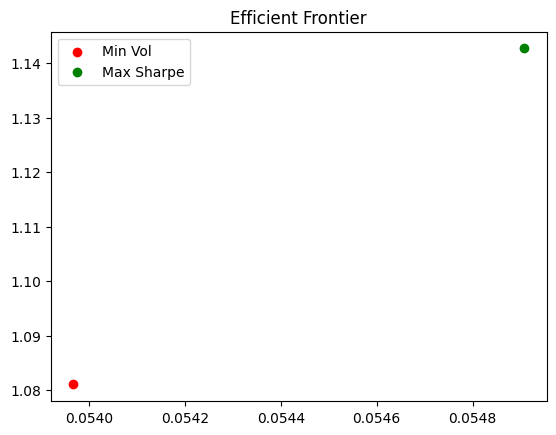

Recommended Portfolio: Weights= OrderedDict([('TSLA', 1.0), ('BND', 0.0), ('SPY', 0.0)]) Exp Return= 1.1426694600773297 Vol= 0.054907559505058094 Sharpe= 20.264412953462816


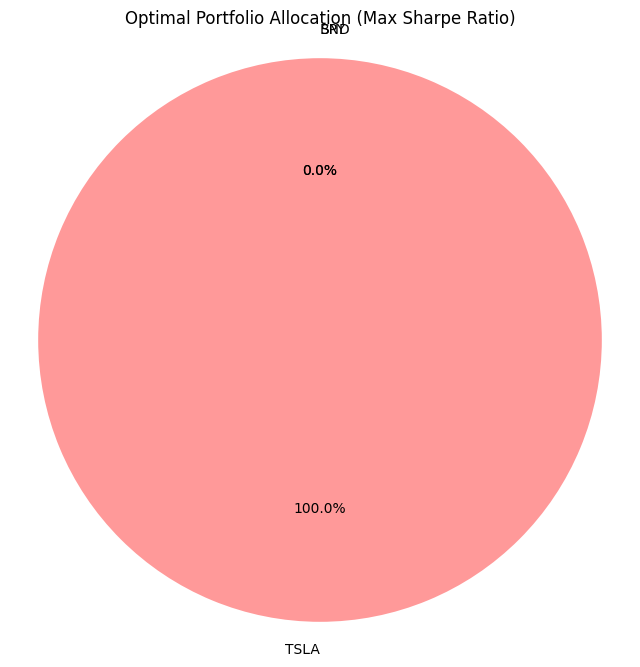

In [18]:
# Task 4: Optimize Portfolio Based on Forecast
# Expected Returns: TSLA from forecast (annualized), others historical
tsla_exp_ret = (forecast.iloc[-1] / adj_close['TSLA'].iloc[-1]) ** (1/1) - 1  # 1-year return
bnd_exp_ret = returns['BND'].mean() * 252
spy_exp_ret = returns['SPY'].mean() * 252
exp_returns = pd.Series([tsla_exp_ret, bnd_exp_ret, spy_exp_ret], index=tickers)

# Covariance Matrix (annualized)
cov_matrix = returns.cov() * 252

# Efficient Frontier using PyPortfolioOpt
ef = EfficientFrontier(exp_returns, cov_matrix)
weights_min_vol = ef.min_volatility()

# Create a new EfficientFrontier instance for max_sharpe
ef_sharpe = EfficientFrontier(exp_returns, cov_matrix)
weights_max_sharpe = ef_sharpe.max_sharpe(risk_free_rate=0.03)  # Assume RF=3%

# Performance
ret_min_vol, vol_min_vol, sharpe_min_vol = ef.portfolio_performance()
ret_max_sharpe, vol_max_sharpe, sharpe_max_sharpe = ef_sharpe.portfolio_performance()

print("Min Volatility Portfolio: Weights=", weights_min_vol, "Return=", ret_min_vol, "Vol=", vol_min_vol, "Sharpe=", sharpe_min_vol)
print("Max Sharpe Portfolio: Weights=", weights_max_sharpe, "Return=", ret_max_sharpe, "Vol=", vol_max_sharpe, "Sharpe=", sharpe_max_sharpe)

# Plot Efficient Frontier
from pypfopt import plotting

# Create a new EfficientFrontier instance for plotting as well
ef_plot = EfficientFrontier(exp_returns, cov_matrix)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_plot, ax=ax)  # Corrected function call and removed show_assets
plt.scatter(vol_min_vol, ret_min_vol, color='red', label='Min Vol')
plt.scatter(vol_max_sharpe, ret_max_sharpe, color='green', label='Max Sharpe')
plt.legend()
plt.title('Efficient Frontier')
plt.savefig('efficient_frontier.png')
# plt.close()
plt.show()

# Recommendation: Max Sharpe for risk-adjusted returns
optimal_weights = weights_max_sharpe
print("Recommended Portfolio: Weights=", optimal_weights, "Exp Return=", ret_max_sharpe, "Vol=", vol_max_sharpe, "Sharpe=", sharpe_max_sharpe)

# Pie Plot for Optimal Portfolio Weights
plt.figure(figsize=(8, 8))
plt.pie(optimal_weights.values(), labels=optimal_weights.keys(), autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Optimal Portfolio Allocation (Max Sharpe Ratio)')
plt.axis('equal')
plt.savefig('portfolio_pie_plot.png')
# plt.close()
plt.show()

# Task 5: Strategy Backtesting (Last Year: Aug 1, 2024 - July 31, 2025)

In [19]:
# Task 5: Strategy Backtesting (Last Year: Aug 1, 2024 - July 31, 2025)
backtest_period = returns['2024-08-01':'2025-07-31']
portfolio_returns = (backtest_period * optimal_weights).sum(axis=1)

# Benchmark: 60% SPY, 40% BND
bench_weights = [0, 0.4, 0.6]
bench_returns = (backtest_period * bench_weights).sum(axis=1)

# Cumulative Returns
cum_port = (1 + portfolio_returns).cumprod()
cum_bench = (1 + bench_returns).cumprod()

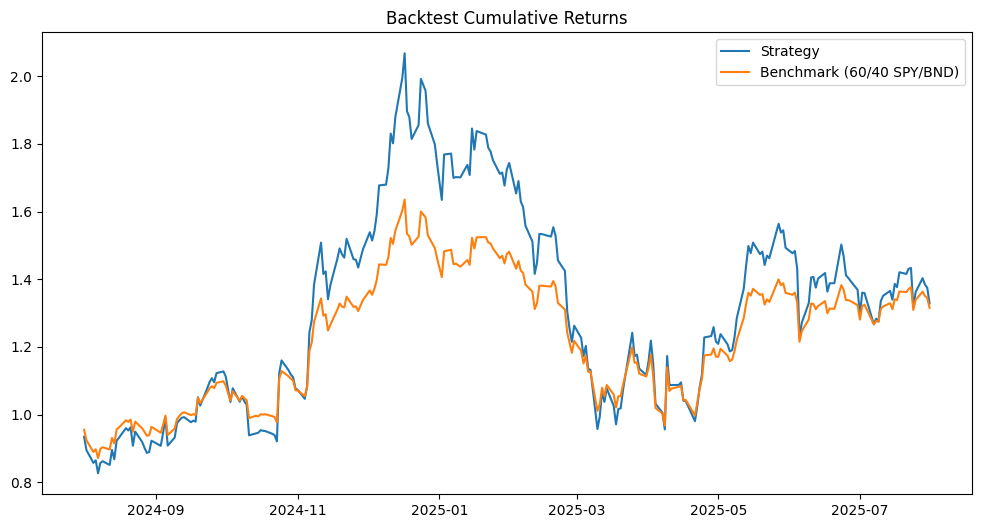

In [20]:
plt.figure(figsize=(12,6))
plt.plot(cum_port, label='Strategy')
plt.plot(cum_bench, label='Benchmark (60/40 SPY/BND)')
plt.title('Backtest Cumulative Returns')
plt.legend()
plt.savefig('backtest_returns.png')
# plt.close()
plt.show()

In [21]:
# Performance Metrics
total_ret_port = cum_port.iloc[-1] - 1
total_ret_bench = cum_bench.iloc[-1] - 1
sharpe_port = (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252))
sharpe_bench = (bench_returns.mean() * 252) / (bench_returns.std() * np.sqrt(252))

print(f"Strategy: Total Return={total_ret_port}, Sharpe={sharpe_port}")
print(f"Benchmark: Total Return={total_ret_bench}, Sharpe={sharpe_bench}")

# Conclusion: If strategy > benchmark, model-driven approach is viable; else, refine forecasts.

Strategy: Total Return=0.3283491157174674, Sharpe=0.7491766663795222
Benchmark: Total Return=0.31523693706724276, Sharpe=0.8029673956349452
